# QSVMs for Market Movement Classification (Angle Encoding Benchmark Tests)

## Background

Quantum Support Vector Machines (QSVMs) are a class of **quantum machine learning algorithms** that leverage **quantum feature maps** to encode classical data into quantum states. By mapping data into a Hilbert space of dimension $2^n$, where $n$ is the number of qubits, QSVMs can exploit the **exponentially large feature space** for constructing similarity measures:

$$
\phi: \mathbb{R}^d \rightarrow \mathcal{H}^{2^n}, \quad x \mapsto |\phi(x)\rangle
$$

The **quantum kernel** between two data points $x$ and $x'$ is defined as the inner product of their quantum feature embeddings:

$$
K(x, x') = |\langle \phi(x) | \phi(x') \rangle|^2
$$

This kernel matrix is then fed into a **classical SVM optimizer**, allowing us to solve the standard SVM dual problem:

$$
\begin{aligned}
\max_{\alpha} \quad & \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_{i,j=1}^m \alpha_i \alpha_j y_i y_j K(x_i, x_j) \\
\text{s.t.} \quad & \sum_{i=1}^m \alpha_i y_i = 0, \quad 0 \le \alpha_i \le C
\end{aligned}
$$

This project benchmarks the performance of **simulated QSVMs** using different quantum kernel matrices and compares them to classical kernels. Specifically, we explore how QSVMs perform as the number of **technical indicators** increases.  

In theory, certain **quantum feature maps** can exploit **entanglement and interference** to capture subtle correlations that classical kernels may miss, potentially producing a more **expressive similarity matrix**:

$$
K_{\text{quantum}} \neq K_{\text{classical}}
$$

Through these experiments, we aim to assess whether QSVMs provide an advantage in capturing complex patterns in financial  datasets.



## Project Introduction

The goal of this project is to investigate how the **number of features or technical indicators** affects the performance of a **Quantum Support Vector Machine (QSVM)**. 

We start with a small set of base features and progressively add additional technical indicators, benchmarking the QSVM's performance as the feature space grows. This allows us to explore whether **quantum feature maps** can capture subtle correlations that classical kernels might miss.  

In this notebook, the **quantum feature map** used is an **Angle Encoding circuit**. This encoding maps each classical feature into the rotation angles of qubits, effectively embedding the data into a high-dimensional Hilbert space:

$$
x \in \mathbb{R}^d \quad \mapsto \quad |\phi(x)\rangle = \bigotimes_{i=1}^{n} R_y(x_i) |0\rangle
$$

Using this embedding, the **quantum kernel** between two data points $x$ and $x'$ is computed as the squared overlap of their quantum states:

$$
K(x, x') = |\langle \phi(x) | \phi(x') \rangle|^2
$$

This produces a **similarity matrix** that is analogous to a **cosine similarity matrix** in classical machine learning, which is then used as input to a classical SVM optimizer.  

By progressively increasing the number of features, we can analyze how **feature richness impacts this kernels feature preformance**.


## Base Feature Implementation

### Imports

In [31]:
# Data Processing Packages
import yfinance as yf
import pandas as pd
import numpy as np
import numpy as np
# -----------------------

# ML Packages
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import accuracy_score
# -----------------------

# Quantum Computing Packages
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane.kernels import square_kernel_matrix, kernel_matrix
import pennylane as qml

# -----------------------

import time
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Initial Feature Set

In [29]:
# Import Data

ticker = "TSLA"
start = "2020-01-01"
end = "2025-01-01"
interval = "1d"
stock_data = yf.download(ticker, start, end, interval, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed


In [32]:
# Feature Selection

stock_features = stock_data[["Open", "High", "Low", "Adj Close", "Volume"]].copy()
stock_features["Log Returns"] = np.log(stock_features["Adj Close"]/stock_features["Adj Close"].shift(1))
stock_features["Price Change"] = stock_features["Adj Close"] - stock_features["Adj Close"].shift(1)
target = (stock_features["Adj Close"].shift(-1) > stock_features["Adj Close"]).astype(int)
data = stock_features.copy()
data['target'] = target

# Clean
data = data.dropna()
features_clean = data.drop(columns=['target'])
labels_clean = data['target']


# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

label_array = labels_clean.to_numpy()





/tmp/ipykernel_813/323389632.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features_clean = data.drop(columns=['target'])


In [33]:
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(features_scaled, label_array, test_size = .3)

### Set Up Quntum Circuit

In [34]:
# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None) 

In [35]:
# QNode: returns state vector for fidelity computation
@qml.qnode(dev, interface="autograd")
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.state()  # vector of size 2^n_qubits

# Vectorized kernel computation using state fidelity
def quantum_kernel_vec(X1, X2):
    # Compute all states once
    states1 = np.array([circut(x, x*0) for x in X1])  # x*0 is a placeholder to avoid double adjoint
    states2 = np.array([circut(x*0, x) for x in X2])
    kernel_matrix = np.abs(states1 @ states2.T)**2
    return kernel_matrix



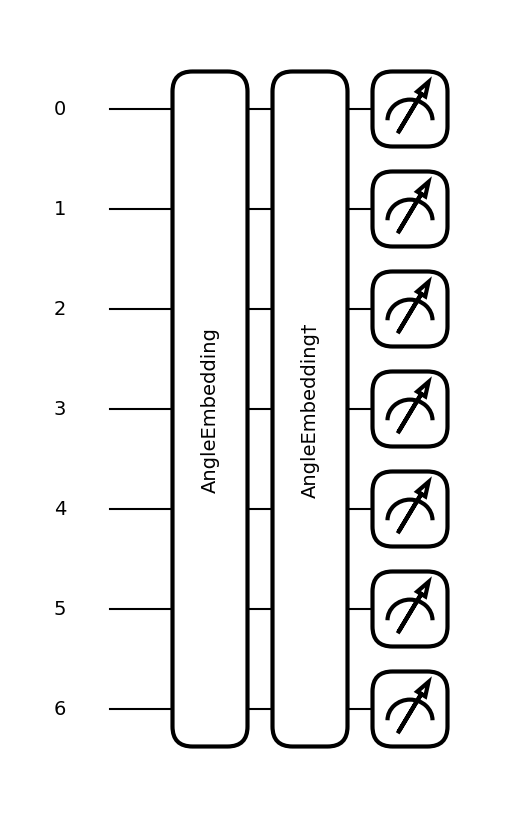

In [36]:
# Circuit Vizualization
x1_sym = [f"x1_{i}" for i in range(n_qubits)]
x2_sym = [f"x2_{i}" for i in range(n_qubits)]


drawer_mpl = qml.draw_mpl(circut)
fig = drawer_mpl(x1_sym, x2_sym)
plt.show()

### Train Kernels/ Get Metrics

In [37]:
# Train Kernels
start = time.time()
train_kernel = quantum_kernel_vec(x_train_1, x_train_1)
print(f"Train kernel shape: {train_kernel.shape}")
print(f"Time for training kernel: {time.time() - start:.2f} seconds")

start = time.time()
test_kernel = quantum_kernel_vec(x_test_1, x_train_1)
print(f"Test kernel shape: {test_kernel.shape}")
print(f"Time for test kernel: {time.time() - start:.2f} seconds")

Train kernel shape: (879, 879)
Time for training kernel: 5.48 seconds
Test kernel shape: (378, 879)
Time for test kernel: 3.97 seconds


In [38]:
# Fit Classical Kernel
clf = SVC(kernel='precomputed')
clf.fit(train_kernel, y_train_1)

y_pred = clf.predict(test_kernel)

In [39]:
scores = {}

def metrics(y_test, test_kernel, y_pred, name):

    # Calculate Metrics
    y_scores = clf.decision_function(test_kernel)
    roc_auc = roc_auc_score(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)


    # Print Results
    print("ROC AUC:", roc_auc)
    print("PR AUC:", pr_auc)
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Accuracy: {accuracy}")


    results = [roc_auc, pr_auc, precision, recall, f1, accuracy]
    scores[name] = results




In [40]:
metrics(y_test_1, test_kernel, y_pred, "t1")

ROC AUC: 0.5371550489879564
PR AUC: 0.550627148757011
Precision: 0.540453074433657
Recall: 0.8391959798994975
F1 Score: 0.65748031496063
Accuracy: 0.5396825396825397


## With Additional Technical Indcators


### Add Momentum

In [41]:
# Reinit Data (Want to Drop NA after adding new features)
data = stock_features.copy()
data['target'] = target

In [42]:
# Momentum 
data["Momentum"] = data["Adj Close"] - data["Adj Close"].shift(10)

In [43]:
data = data.dropna()
features_clean = data.drop(columns=['target'])
labels_clean = data['target']


# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

label_array = labels_clean.to_numpy()

/tmp/ipykernel_813/2559791590.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features_clean = data.drop(columns=['target'])


In [46]:
# Recrate Circuit WIth More Qubits
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(features_scaled, label_array, test_size = .3)

n_qubits = x_train_2.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)


In [48]:
# Resize Circuit
# QNode: returns state vector for fidelity computation
@qml.qnode(dev, interface="autograd")
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.state()  # vector of size 2^n_qubits


In [49]:
# Train Kernels
start = time.time()
train_kernel = quantum_kernel_vec(x_train_2, x_train_2)
print(f"Train kernel shape: {train_kernel.shape}")
print(f"Time for training kernel: {time.time() - start:.2f} seconds")

start = time.time()
test_kernel = quantum_kernel_vec(x_test_2, x_train_2)
print(f"Test kernel shape: {test_kernel.shape}")
print(f"Time for test kernel: {time.time() - start:.2f} seconds")

Train kernel shape: (873, 873)
Time for training kernel: 5.75 seconds
Test kernel shape: (375, 873)
Time for test kernel: 4.41 seconds


In [51]:
# Fit Classical Kernel
clf = SVC(kernel='precomputed')
clf.fit(train_kernel, y_train_2)

y_pred_2 = clf.predict(test_kernel)

In [52]:
metrics(y_test_2, test_kernel, y_pred_2, "t1")

ROC AUC: 0.49383720930232555
PR AUC: 0.5728047828173337
Precision: 0.5683760683760684
Recall: 0.6186046511627907
F1 Score: 0.5924276169265034
Accuracy: 0.512


### Add RSI

In [76]:
# Realative Strenght Index
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data["RSI"] = compute_rsi(data["Adj Close"])




In [77]:

data = data.dropna()
features_clean = data.drop(columns=['target'])
labels_clean = data['target']


/tmp/ipykernel_813/3865547228.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features_clean = data.drop(columns=['target'])


In [78]:
# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

label_array = labels_clean.to_numpy()

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(features_scaled, label_array, test_size = .3)

In [79]:
# Resize Circuit

n_qubits = x_train_3.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)


@qml.qnode(dev, interface="autograd")
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.state()  # vector of size 2^n_qubits


In [80]:
# Train Kernels
start = time.time()
train_kernel = quantum_kernel_vec(x_train_3, x_train_3)
print(f"Train kernel shape: {train_kernel.shape}")
print(f"Time for training kernel: {time.time() - start:.2f} seconds")

start = time.time()
test_kernel = quantum_kernel_vec(x_test_3, x_train_3)
print(f"Test kernel shape: {test_kernel.shape}")
print(f"Time for test kernel: {time.time() - start:.2f} seconds")

Train kernel shape: (851, 851)
Time for training kernel: 8.44 seconds
Test kernel shape: (365, 851)
Time for test kernel: 6.62 seconds


In [83]:
# Fit Classical Kernel
clf = SVC(kernel='precomputed')
clf.fit(train_kernel, y_train_3)

y_pred_3 = clf.predict(test_kernel)

In [84]:
metrics(y_test_3, test_kernel, y_pred_3, "t1")

ROC AUC: 0.5231831831831832
PR AUC: 0.5224055280525526
Precision: 0.5181818181818182
Recall: 0.6162162162162163
F1 Score: 0.562962962962963
Accuracy: 0.5150684931506849


### Bollinger Bands

In [72]:
window = 20
std_mult = 2

sma = data["Adj Close"].rolling(window).mean()
std = data["Adj Close"].rolling(window).std()

data["BB_Position"] = (
    (data["Adj Close"] - (sma - std_mult * std))
    / ((sma + std_mult * std) - (sma - std_mult * std))
)

data["BB_Width"] = (2 * std_mult * std) / sma


In [74]:

data = data.dropna()
features_clean = data.drop(columns=['target'])
labels_clean = data['target']


/tmp/ipykernel_813/3865547228.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  features_clean = data.drop(columns=['target'])


In [81]:
# Scale
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

label_array = labels_clean.to_numpy()

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(features_scaled, label_array, test_size = .3)

In [85]:
# Resize Circuit

n_qubits = x_train_4.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits, shots=None)


@qml.qnode(dev, interface="autograd")
def circut(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.state()  # vector of size 2^n_qubits

In [86]:
# Train Kernels
start = time.time()
train_kernel = quantum_kernel_vec(x_train_4, x_train_4)
print(f"Train kernel shape: {train_kernel.shape}")
print(f"Time for training kernel: {time.time() - start:.2f} seconds")

start = time.time()
test_kernel = quantum_kernel_vec(x_test_4, x_train_4)
print(f"Test kernel shape: {test_kernel.shape}")
print(f"Time for test kernel: {time.time() - start:.2f} seconds")

Train kernel shape: (851, 851)
Time for training kernel: 9.13 seconds
Test kernel shape: (365, 851)
Time for test kernel: 6.58 seconds


In [88]:
# Fit Classical Kernel
clf = SVC(kernel='precomputed')
clf.fit(train_kernel, y_train_4)

y_pred_4 = clf.predict(test_kernel)

In [89]:
metrics(y_test_4, test_kernel, y_pred_4, "t1")

ROC AUC: 0.5621283824778546
PR AUC: 0.6126365511958579
Precision: 0.583732057416268
Recall: 0.6069651741293532
F1 Score: 0.5951219512195122
Accuracy: 0.5452054794520548
